In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
from os.path import join
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from core.img_patch_stats_analysis_lib import *
from core.img_patch_stats_analysis_lib import compute_crossing_points, harmonic_mean, smooth_and_find_threshold_crossing
from circuit_toolkit.plot_utils import saveallforms

In [4]:
from os.path import join
import torch
# from core.edm_dataset import load_dataset

def load_dataset(dataset_name, normalize=True):
    import sys
    sys.path.append("/n/home12/binxuwang/Github/edm")
    from training.dataset import TensorDataset, ImageFolderDataset
    edm_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/datasets"
    if dataset_name == "FFHQ":
        edm_ffhq64_path = join(edm_dataset_root, "ffhq-64x64.zip")
        dataset = ImageFolderDataset(edm_ffhq64_path)
        imgsize = 64
    elif dataset_name == "AFHQ":
        edm_afhq_path = join(edm_dataset_root, "afhqv2-64x64.zip")
        dataset = ImageFolderDataset(edm_afhq_path)
        imgsize = 64
    elif dataset_name == "CIFAR":
        edm_cifar_path = join(edm_dataset_root, "cifar10-32x32.zip")
        dataset = ImageFolderDataset(edm_cifar_path)
        imgsize = 32
    print(f"{dataset_name} dataset: {len(dataset)}")
    print(f"value range" , (dataset[0][0].max()), (dataset[0][0].min()))
    Xtsr_raw = torch.stack([torch.from_numpy(dataset[i][0]) for i in range(len(dataset))]) / 255.0
    if normalize:
        print("Normalizing dataset to [-1.0, 1.0]")
        Xtsr = (Xtsr_raw - 0.5) / 0.5
    else:
        Xtsr = Xtsr_raw
    return Xtsr, imgsize


### CIFAR10 lr small 1E-4

In [5]:
Xtsr, imgsize = load_dataset("CIFAR", normalize=True)
savedir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/CIFAR10_UNet_CNN_EDM_3blocks_wide128_attn_pilot_fixednorm_smalllr"
sampledir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/CIFAR10_UNet_CNN_EDM_3blocks_wide128_attn_pilot_fixednorm_smalllr/samples"
sample_store = sweep_and_create_sample_store(sampledir)

CIFAR dataset: 50000
value range 255 0
Normalizing dataset to [-1.0, 1.0]


  0%|          | 0/494 [00:00<?, ?it/s]

In [6]:
patch_size, patch_stride = 3, 1
step_slice = sorted(sample_store.keys())
patch_mean, patch_cov, patch_eigval, patch_eigvec, mean_x_patch_sample_traj, cov_x_patch_sample_traj, diag_cov_x_patch_sample_true_eigenbasis_traj = \
     process_patch_mean_cov_statistics(Xtsr, sample_store, savedir, patch_size=patch_size, patch_stride=patch_stride, device="cuda", imgshape=(3, 32, 32))

patch_cov.shape: torch.Size([27]) computed on 50000 images


  0%|          | 0/494 [00:00<?, ?it/s]

Saved to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/CIFAR10_UNet_CNN_EDM_3blocks_wide128_attn_pilot_fixednorm_smalllr/sample_patch_3x3_stride_1_cov_true_eigenbasis_diag_traj.pkl


No crossing found for mode 0


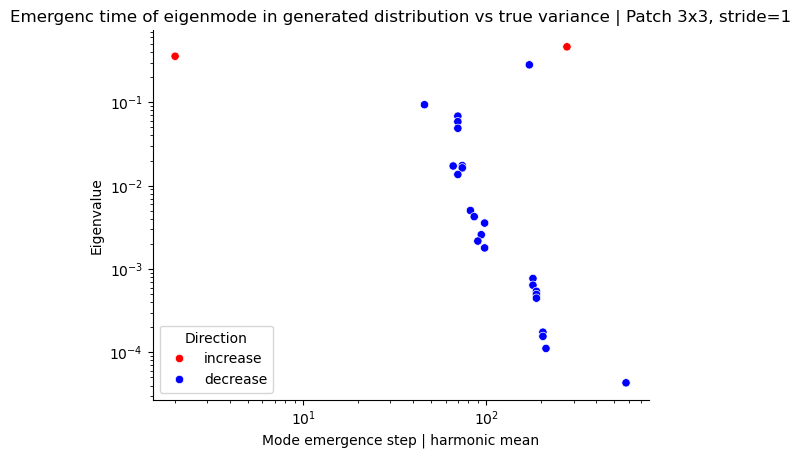

In [7]:
df = compute_crossing_points(patch_eigval, diag_cov_x_patch_sample_true_eigenbasis_traj, step_slice, smooth_sigma=2)
df.to_csv(f"{savedir}/synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance.csv", index=False)

sns.scatterplot(data=df, x="emergence_step", y="Variance", hue="Direction", palette={"increase": "red", "decrease": "blue"})
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mode emergence step | harmonic mean")
plt.ylabel("Eigenvalue")
plt.title(f"Emergence time of eigenmode in generated distribution vs true variance | Patch {patch_size}x{patch_size}, stride={patch_stride}")
saveallforms(savedir, f"synopsis_patch_{patch_size}x{patch_size}_stride_{patch_stride}_eigenmode_emergence_harmonic_mean_vs_variance")
plt.show()